In [ ]:
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ImportWarning)

import tensorflow as tf

In [19]:
N, M = 60, 60
noise = np.random.uniform(size = (N,M,3)) #original map

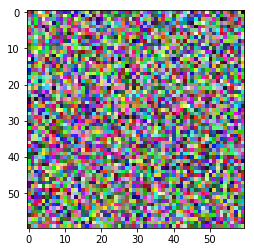

In [20]:
plt.imshow(noise)

In [21]:
#often SOMs perform better when weights are initialized by the grid from the space spanned by first several PCA components of the data.
#This code section builds the map of PCA 0 component of original noisy image for SOM initialization
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(np.reshape(noise, newshape=(N*M,3)))

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca.explained_variance_ratio_ #explained ratio should be equal to ~1/3, since our original image is random noise

array([0.34343552])

In [23]:
grid = np.arange(0, 1, step = 1/(N*M))
pca_0_direction = pca.components_[0] #direction of O component of pca

dists_flat = np.argsort([(i%N)**2 + (i//N)**2 for i in range(N*M)]) #Coordinates of flattened image sorted by their distance from the upper left corner of the image

dists_grid = np.zeros([N*M])
dists_grid[dists_flat] = np.arange(0,N*M, 1) #NxM matrix with entries equal to their rank based on the distance from upper left corner

pca_grid = np.array([list(grid[int(i)]*pca_0_direction) for i in dists_grid]) #flattened NxM grid with entries parallel to PCA 0 component, 
                                                                              #from min to max values of the original image along the pca_0_diretion 
pca_grid = np.reshape(pca_grid, newshape=[N,M,3])
pca_grid = pca_grid + np.int8(pca_0_direction < 0 ) #bringing negative components of PCA to [0,1] range 

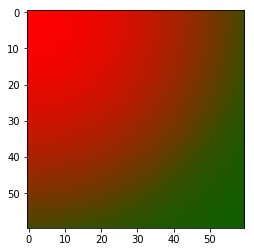

In [24]:
plt.imshow(pca_grid)
plt.show()

In [25]:
inp_plhd = tf.placeholder(dtype = tf.float32, shape = [None, 3]) #placeholder for training batch
lr = tf.placeholder_with_default(0.003, shape = ())  #learning rate
inv_r_square = tf.placeholder_with_default(1/8, shape = ())   #inverse r^2, learning hyperparameter
var_init = tf.placeholder_with_default(pca_grid.astype(np.float32), shape = [N,M,3])   #placeholder holding the value of grid along the PCA 0 direction

#these 2 are placeholders holding correspondingly the X and Y coordinate values of NxM grid. They are defined as placeholders in order for
#the training procedure to be able to change the batch size dynamically during training
X_grid = tf.placeholder(dtype = tf.int64, shape=(None, N, M)) 
Y_grid = tf.placeholder(dtype = tf.int64, shape=(None, N, M))

with tf.variable_scope('weights'):
    #weights = tf.get_variable(shape = [N, M, 3], initializer=tf.truncated_normal_initializer(), name = 'weights', dtype = tf.float32)
    weights = tf.get_variable(initializer=var_init, name = 'weights', dtype = tf.float32) #weights initialized by PCA 0 component of the data

In [26]:
smpl = tf.reshape(inp_plhd, shape = [-1, 1, 1, 3])

In [27]:
dists_from_smpl = tf.norm(weights - smpl, axis = 3) #distances of training batch from SOM cells

In [28]:
dists_reshaped = tf.reshape(dists_from_smpl, shape = [-1, N*M])

In [29]:
argmin = tf.argmin(dists_reshaped, axis = 1)

In [30]:
argmin_i, argmin_j = argmin // M, argmin % M #coordinates of best matching unit

In [31]:
weights_bmu = tf.gather_nd(weights, tf.stack([argmin_i, argmin_j], axis=1)) #best matching unit weights

In [32]:
loss = tf.reduce_mean(tf.square(weights_bmu - inp_plhd))

In [33]:
X_grid_rel = X_grid - tf.reshape(argmin_i, (-1,1,1))  #differences of X and Y coordinate grids from best matching unti coordinates
Y_grid_rel = Y_grid - tf.reshape(argmin_j, (-1,1,1))

In [34]:
inv_r_square_ = tf.scalar_mul(-0.5, inv_r_square)

In [35]:
exp = tf.cast(inv_r_square_, tf.float32) * tf.cast(tf.square(X_grid_rel) + tf.square(Y_grid_rel), dtype = tf.float32)
h = tf.exp(exp) #coefficients for SOM weight updates based on distance cells' distance from best matching units. Weights update measure decays exponentially with the distance from 
                #best matching unit 

In [36]:
grads = tf.multiply(tf.reshape(h, [-1, N, M, 1]), smpl - weights)*lr 

In [37]:
grads_mini_batch = tf.reduce_mean(grads, axis = 0) #gradients for batch

In [38]:
weights_update_op = tf.assign_add(weights, grads_mini_batch)

In [46]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [47]:
#function for bulding X_grid and Y_grid placeholders for training
def get_coord_grid(coord, batch_size):
    if coord == 'x':
        return np.stack([np.reshape(np.arange(N*M)//M, (N, M)) for _ in range(batch_size)])
    elif coord == 'y':
        return np.stack([np.reshape(np.arange(N*M)%M, (N, M)) for _ in range(batch_size)])
    else:
        print ('Wrong argument provided')
        return 0

In [48]:
loss_progress = []
batch_size = 15 #first stage of the training, big batch size, small inv_r^2 (i.e. big radius for weight update)
lrate, inv_r_sq  = 0.03, 1/22 
for train_iter in range(20000):
    rand_color = noise[np.random.randint(N, size=batch_size), np.random.randint(M, size=batch_size), :] 
    rand_color= np.reshape(rand_color, (batch_size,3)) #training batch
    
    new_weights = sess.run(weights_update_op, feed_dict = {inp_plhd : rand_color, lr : lrate, inv_r_square : inv_r_sq, X_grid: get_coord_grid('x', batch_size), 
                                                          Y_grid: get_coord_grid('y', batch_size)})
    
    if train_iter % 100 == 0:
        loss_progress.append(sess.run(loss, feed_dict={inp_plhd : np.reshape(noise, [N*M,3])}))
    
    if train_iter %2000 == 0:
        lrate = lrate*9/10
        if 1/inv_r_sq >= 4:
            inv_r_sq = 1/(1/inv_r_sq-1)
        print ('Iteration ' + str(train_iter) + ', loss: ' + str(loss_progress[-1]))

Iteration 0, loss: 0.1638842
Iteration 2000, loss: 0.010586129
Iteration 4000, loss: 0.0082444465
Iteration 6000, loss: 0.0070910333
Iteration 8000, loss: 0.0064013437
Iteration 10000, loss: 0.005870671
Iteration 12000, loss: 0.005450668
Iteration 14000, loss: 0.0050835935
Iteration 16000, loss: 0.004807183
Iteration 18000, loss: 0.0045195953


In [49]:
lrate, inv_r_sq

(0.010460353203, 0.08333333333333333)

In [50]:
lrate = 0.01
inv_r_sq = 1/3
batch_size = 10 #increasing bach size, decreasing inverse r^2 for the second stage of the training
for train_iter in range(5000):
    rand_color = noise[np.random.randint(N, size=batch_size), np.random.randint(M, size=batch_size), :]
    rand_color= np.reshape(rand_color, (batch_size,3))
    
    new_weights = sess.run(weights_update_op, feed_dict = {inp_plhd : rand_color, lr : lrate, inv_r_square : inv_r_sq, X_grid: get_coord_grid('x', batch_size), 
                                                          Y_grid: get_coord_grid('y', batch_size)})
    
    if train_iter % 100 == 0:
        loss_progress.append(sess.run(loss, feed_dict={inp_plhd : np.reshape(noise, [N*M,3])}))
    
    if train_iter %500 == 0:
        lrate = lrate*9/10
        if 1/inv_r_sq >= 1.1:
            inv_r_sq = 1/(1/inv_r_sq-0.2)
        print ('Iteration ' + str(train_iter) + ', loss: ' + str(loss_progress[-1]))

Iteration 0, loss: 0.004284225
Iteration 500, loss: 0.004174178
Iteration 1000, loss: 0.0040759915
Iteration 1500, loss: 0.003996176
Iteration 2000, loss: 0.0039291466
Iteration 2500, loss: 0.0038744276
Iteration 3000, loss: 0.003824886
Iteration 3500, loss: 0.0037843424
Iteration 4000, loss: 0.0037511557
Iteration 4500, loss: 0.003724248


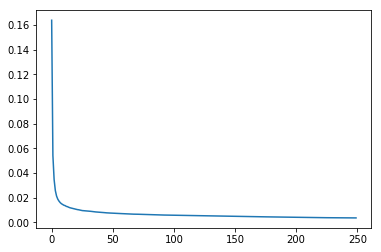

In [51]:
plt.plot(loss_progress)
plt.show()

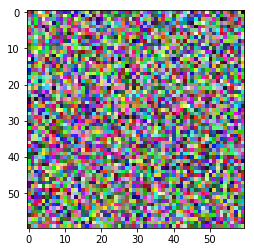

In [53]:
plt.imshow(noise) #original data points

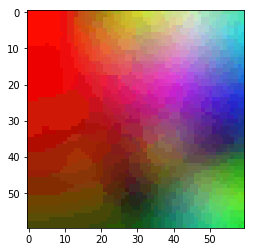

In [52]:
new_pic = np.zeros([N, M, 3])
for i in range(N):
    for j in range(M):
        dd = np.reshape(np.linalg.norm((new_weights[i,j,:] - noise), axis = 2), [N*M])
        argmin_dist = np.argmin(dd)
        argmin_dist_i, argmin_dist_j = argmin_dist // M, argmin_dist % M
        new_pic[i, j] = noise[argmin_dist_i, argmin_dist_j]
plt.imshow(new_pic) #SOM